# Import Libraries

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [2]:
#!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.7 MB/s eta 0:00:00


# Create helper functions

In [36]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-05-11 21:00:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-11 21:00:17 (98.8 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



# Load dan Transform Data

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
BATCH_SIZE = 32
IMAGE_SIZE = (320, 320)

In [37]:
dataset = "/content/drive/MyDrive/Orbit/fire_dataset"
walk_through_dir(dataset)

There are 2 directories and 0 images in '/content/drive/MyDrive/Orbit/fire_dataset'.
There are 0 directories and 755 images in '/content/drive/MyDrive/Orbit/fire_dataset/fire_images'.
There are 0 directories and 244 images in '/content/drive/MyDrive/Orbit/fire_dataset/non_fire_images'.


# simpan data ke dalam Dataframe


In [12]:
image_dir = Path(dataset)

# Get filepaths dan labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Gabungkan filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [13]:
len(list(image_dir.glob(r'**/*.png')))

999

In [14]:
image_df

Filepath            Label
0    /content/drive/MyDrive/Orbit/fire_dataset/fire...      fire_images
1    /content/drive/MyDrive/Orbit/fire_dataset/fire...      fire_images
2    /content/drive/MyDrive/Orbit/fire_dataset/fire...      fire_images
3    /content/drive/MyDrive/Orbit/fire_dataset/fire...      fire_images
4    /content/drive/MyDrive/Orbit/fire_dataset/fire...      fire_images
..                                                 ...              ...
994  /content/drive/MyDrive/Orbit/fire_dataset/non_...  non_fire_images
995  /content/drive/MyDrive/Orbit/fire_dataset/non_...  non_fire_images
996  /content/drive/MyDrive/Orbit/fire_dataset/non_...  non_fire_images
997  /content/drive/MyDrive/Orbit/fire_dataset/non_...  non_fire_images
998  /content/drive/MyDrive/Orbit/fire_dataset/non_...  non_fire_images

[999 rows x 2 columns]

# Visualizing images from the dataset

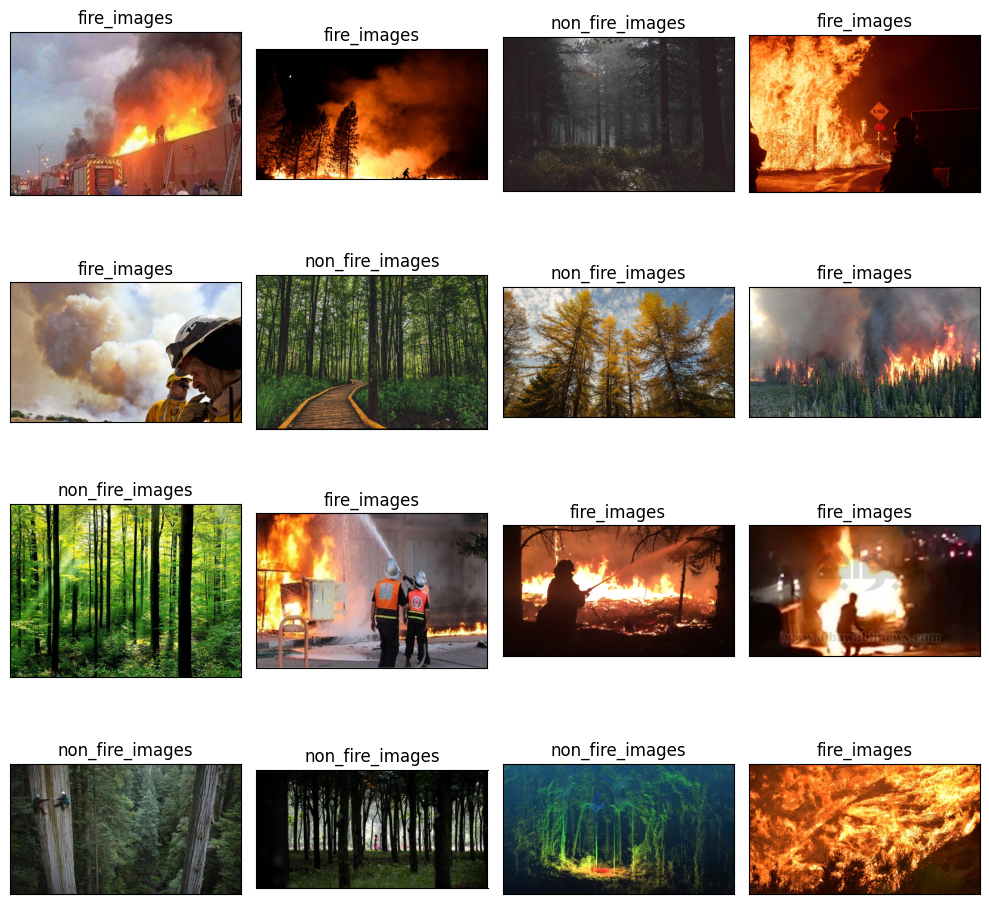

In [38]:
import matplotlib.image as mpimg
# tampilkan 16 gambar dari dataset dengan label
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(image_df.Filepath[random_index[i]])
    ax.imshow(image)
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# Data Preprocessing

Data akan dibagi menjadi 3 kategori yaitu Training, Validation, dan Testing. Data Training akan digunakan untuk melatih model CNN deep learning dan parameternya akan diselaraskan dengan data validation. Terakhir, data akan dievaluasi menggunakan data test.

In [39]:
# pisahkan train dan test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [17]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [40]:
# Split the data menjadi 3 kategori.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 640 validated image filenames belonging to 2 classes.
Found 159 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [19]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Training the model

Model gambar akan disubjekkan menjadi pre-trained CNN model yang disebut MobileNetV2. Ada 3 callback yang akan digunakan untuk memonitor training yaitu callback Model Checkpoint, Early Stopping, Tensorboard. Ringkasan dari model hyperparameter yaitu :

**Batch size** : 32

**Epochs** : 100

**Input Shape** : (320, 320, 3)

**Output layer** : 1



In [20]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [21]:
# Create checkpoint callback
checkpoint_path = "fires_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [22]:
# Setup EarlyStopping callback untuk menghentikan proses training jika val_loss pada model tidak bisa muncul sampai 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # metric val loss
                               patience = 5,
                               restore_best_weights = True) # jika val_loss mengurangi 3 epoch berturut-turut, maka stop training

# Training the model

In [23]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "fire_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/fire_classification/20230511-190558
Epoch 1/100
20/20 [==============================] - 300s 15s/step - loss: 0.4194 - accuracy: 0.7891 - val_loss: 0.2068 - val_accuracy: 0.9371
Epoch 2/100
20/20 [==============================] - 68s 3s/step - loss: 0.1825 - accuracy: 0.9406 - val_loss: 0.1351 - val_accuracy: 0.9560
Epoch 3/100
20/20 [==============================] - 68s 3s/step - loss: 0.1071 - accuracy: 0.9781 - val_loss: 0.1086 - val_accuracy: 0.9560
Epoch 4/100
20/20 [==============================] - 70s 3s/step - loss: 0.0812 - accuracy: 0.9781 - val_loss: 0.0967 - val_accuracy: 0.9623
Epoch 5/100
20/20 [==============================] - 68s 3s/step - loss: 0.0585 - accuracy: 0.9844 - val_loss: 0.0893 - val_accuracy: 0.9623
Epoch 6/100
20/20 [==============================] - 68s 3s/step - loss: 0.0466 - accuracy: 0.9937 - val_loss: 0.0840 - val_accuracy: 0.9686
Epoch 7/100
20/20 [==============================] - 67s 3s/step - lo

# Model Evaluation



In [24]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.04342
Test Accuracy: 98.00%


# Visualizing loss curves

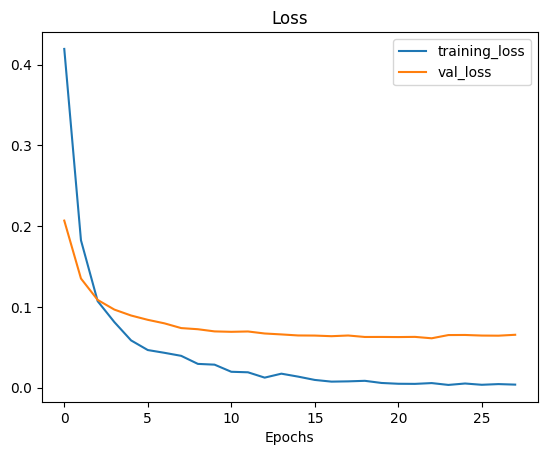

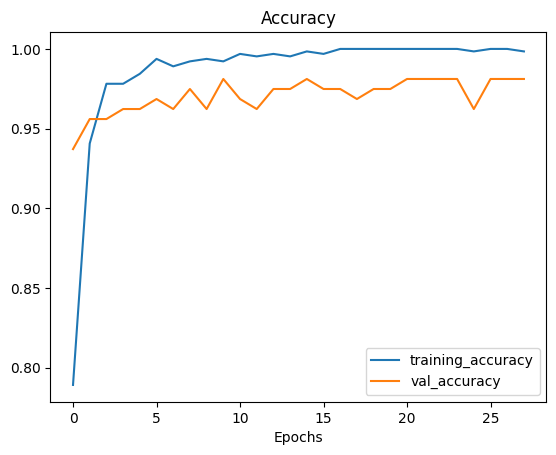

In [25]:
plot_loss_curves(history)

# Melakukan Prediksi pada data Test 

In [26]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

7/7 [==============================] - 19s 3s/step
The first 5 predictions: ['fire_images', 'non_fire_images', 'fire_images', 'fire_images', 'fire_images']


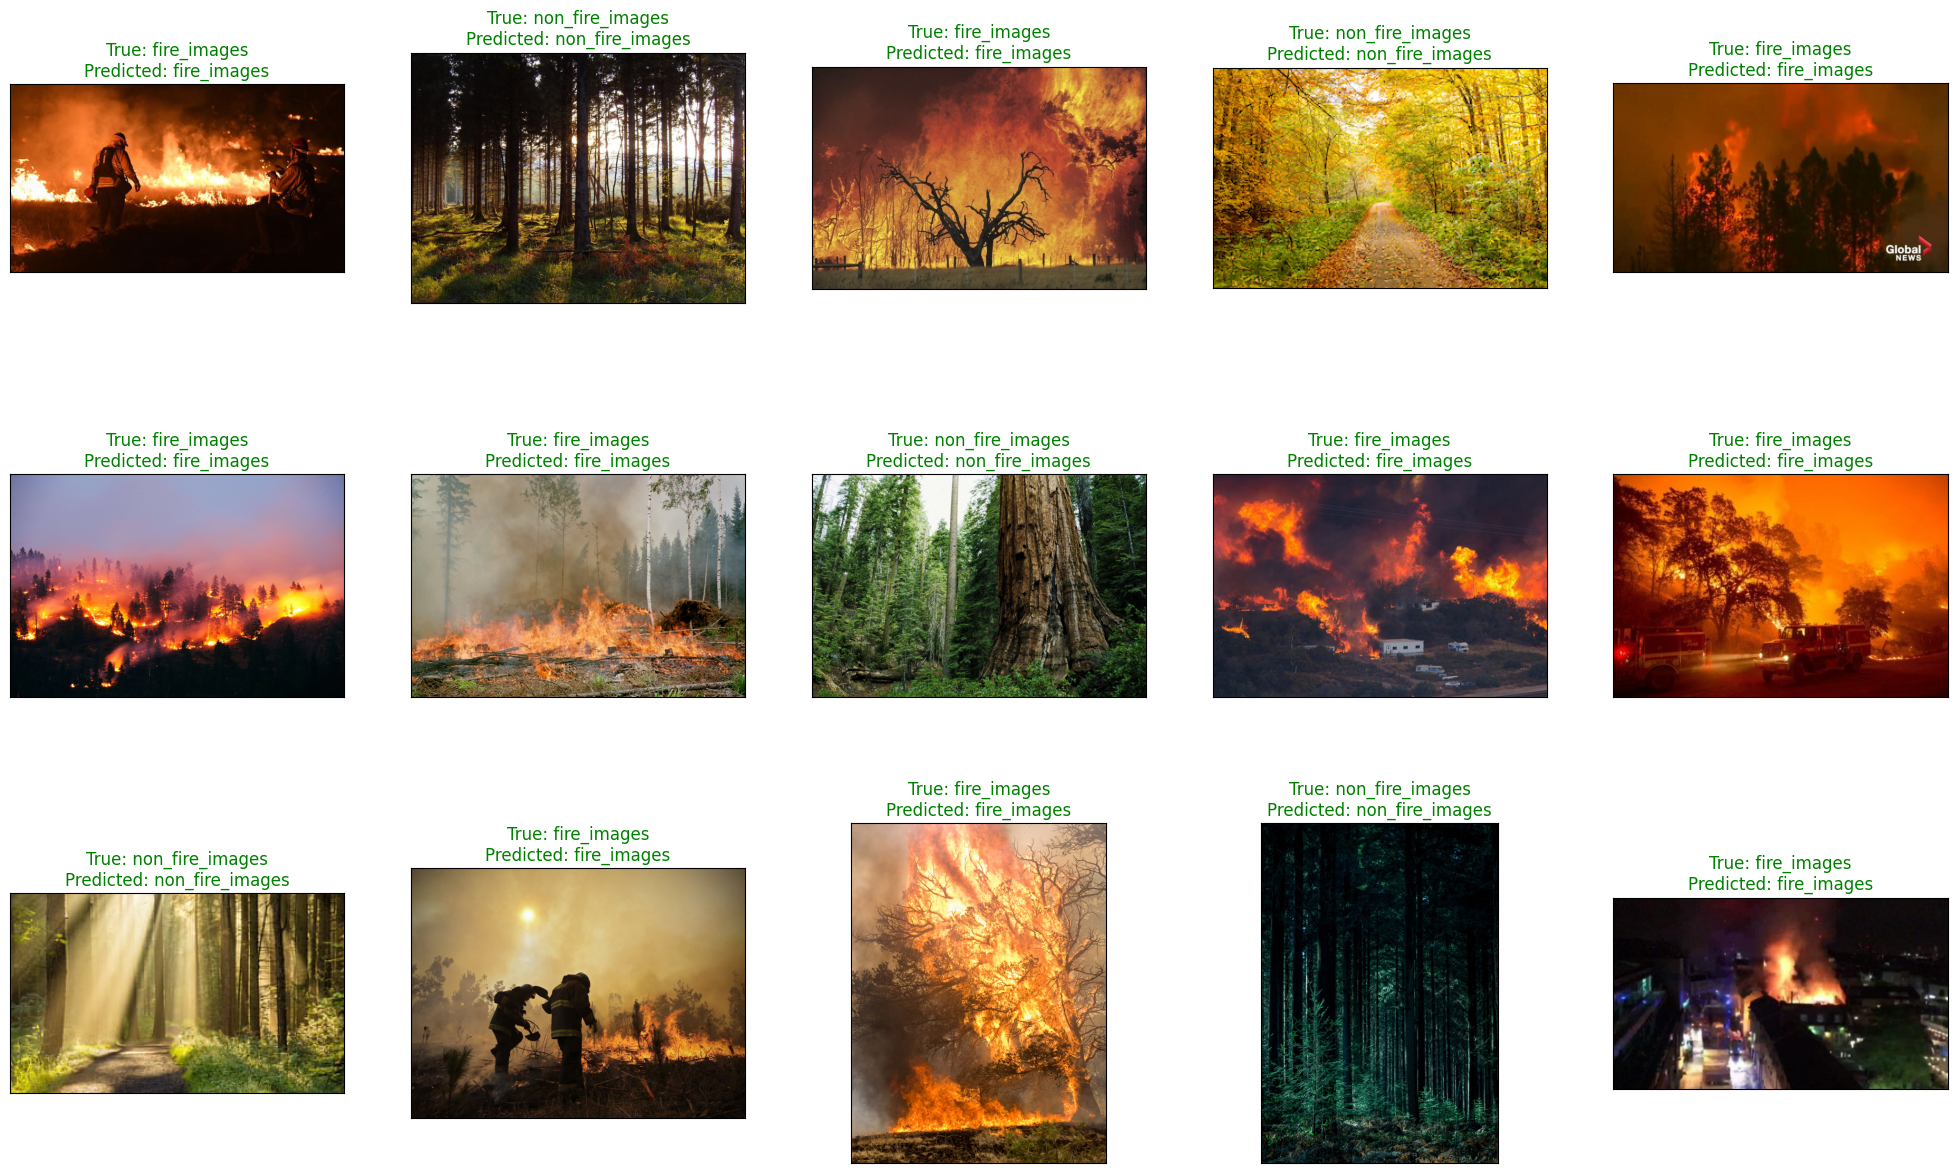

<Figure size 640x480 with 0 Axes>

In [41]:
  # Tampilkan 25 gamar secara random dari dataset dengan label-labelnya.
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(test_df.Filepath.iloc[random_index[i]])
    ax.imshow(image)
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# Classification Reports dan Confusion Matrix

In [28]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                 precision    recall  f1-score   support

    fire_images       0.97      1.00      0.99       148
non_fire_images       1.00      0.92      0.96        52

       accuracy                           0.98       200
      macro avg       0.99      0.96      0.97       200
   weighted avg       0.98      0.98      0.98       200



In [29]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score  support
fire_images       0.973684  1.000000  0.986667   148.00
non_fire_images   1.000000  0.923077  0.960000    52.00
accuracy          0.980000  0.980000  0.980000     0.98
macro avg         0.986842  0.961538  0.973333   200.00
weighted avg      0.980526  0.980000  0.979733   200.00

In [43]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
    
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] 
    n_classes = cm.shape[0] 

    # Plot the figure
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # warna akan merepresentasikan seberapa benar kelas nya dan semakin gelap warna nya maka semakin bagus.
    fig.colorbar(cax)
    
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes), 
         xticklabels=labels, 
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure 
    if savefig:
        fig.savefig('/content/drive/MyDrive/Orbit/confusion_matrix.png')


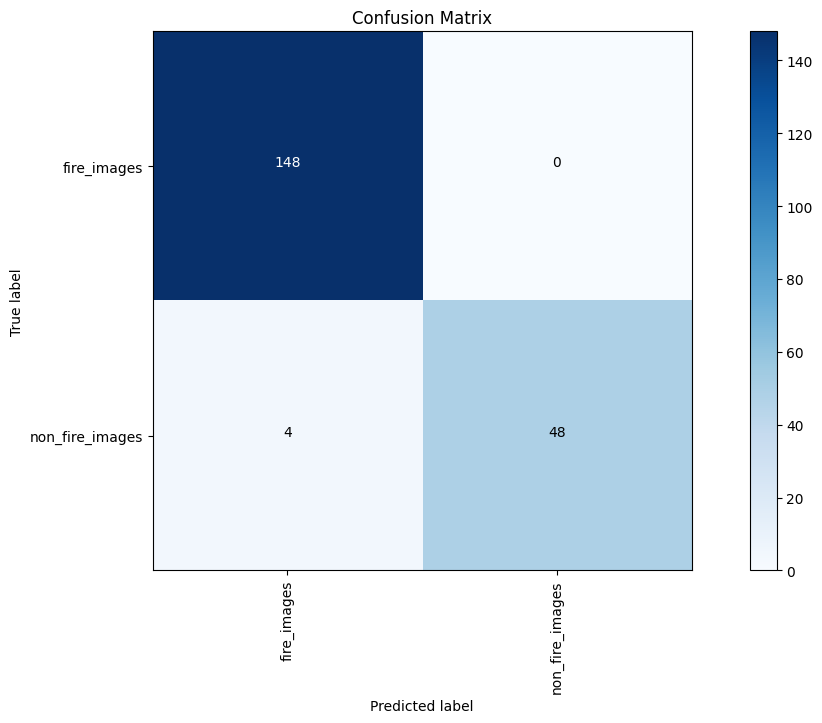

In [31]:
make_confusion_matrix(y_test, pred, list(labels.values()))

In [33]:
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/Orbit/model_fire_dataset.h5')